# Generate dataframes for analysis

1. All reviews for nominees to predict winner/loser
2. 2013-2017 for predicting 2017 nominees

## All reviews for nominees

In [15]:
import pandas as pd
import numpy as np
import logging
import json

pd.options.display.max_columns=None

#Load files function
#Limit to XXXX observations for testing
def load_data(file_name):
    count = 0
    data = []
    with open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)            
    return data
reviewsFP = load_data('goodreads_reviews_fantasy_paranormal.json')
reviews = pd.DataFrame(reviewsFP)
print(len(reviews))

In [16]:
cols = pd.read_csv('combo-awards.csv',nrows=1).columns
awards = pd.read_csv('combo-awards.csv',usecols=cols[1:],dtype={'bookID':str})
#print(awards.dtypes)
awards['winner']=np.where(awards['Nominee']==0,1,0)
awards.rename(columns={'Nominee':'loser'},inplace=True)
#print(awards.head())

awardReviews = pd.merge(awards,reviews,left_on='bookID',right_on='book_id',how='inner')
print(awardReviews.head())

awardReviews.to_csv('awardReviews.csv',index=False)

In [20]:
awardReviews=pd.read_csv('awardReviews.csv')

In [ ]:
awards.head()
#awards[awards.winner==1].book_id.nunique()/awards.book_id.nunique()

## 2013 - 2017 data for predicting winners



In [ ]:
reviews['reviewDate'] = pd.to_datetime(reviews.date_added,utc=True)

In [ ]:
from datetime import datetime
#reviews['reviewDate']=reviews['reviewDate'].tz_convert(None)
reviews[reviews['reviewDate'].dt.year>=2013].to_csv('reviews_2013-on.csv')

## Sample and split

In [21]:
#load
reviews = pd.read_pickle('reviews_2013-on.pkl')

How many reviews and award books are in 2016?

In [4]:
reviews[reviews['reviewDate'].dt.year==2016].count()

user_id         513276
book_id         513276
review_id       513276
rating          513276
review_text     513276
date_added      513276
date_updated    513276
read_at         513276
started_at      513276
n_votes         513276
n_comments      513276
reviewDate      513276
dtype: int64

The problem with the thing is that it doesn't work. The theory is that it's because of how imbalanced it is with the number of reviews there. We can look at winners/losers and split it up.

In [22]:
reviewAwards = pd.merge(reviews,awards,right_on='bookID',left_on='book_id',how='left')
reviewAwards['awardNominee'] = reviewAwards['award'].notna().astype(int)
reviewAwardsClass = reviewAwards[['book_id','review_text','n_votes','reviewDate','awardNominee']].rename(columns={'review_text':'text','awardNominee':'labels'})
reviewAwardsClass = reviewAwardsClass[reviewAwardsClass['text'].notna()]
print(reviewAwardsClass.head())
#reviews[['book_id',''.nunique()

    book_id                                               text  n_votes  \
0  18245960  This is a special book. It started slow for ab...       28   
1   5577844  A beautiful story. Neil Gaiman is truly a uniq...        5   
2  17315048  Mark Watney is a steely-eyed missile man. A ma...       25   
3  15706923  Ehhhhhh. \n Really nothing to rave about. It w...        0   
4   7840190  Enjoyable read! I liked that Connie is not a t...        0   

                 reviewDate  labels  
0 2017-07-30 14:44:10+00:00       0  
1 2014-09-24 16:29:29+00:00       0  
2 2014-04-05 16:30:53+00:00       0  
3 2013-11-09 04:14:53+00:00       0  
4 2013-11-09 03:57:47+00:00       0  


In [23]:
reviewAwardsClass[reviewAwardsClass['labels']==1].nunique()

book_id          913
text          137944
n_votes          229
reviewDate    140895
labels             1
dtype: int64

## How to handle imbalanced data 

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

We will sample 3x as many books as we have award winners (913 award winners) and then try to oversample to more balanced data.


In [6]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

y = reviewAwardsClass.labels
X = reviewAwardsClass.drop('labels',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
Not_Nominee = X[X.labels==0]
Yes_Nominee = X[X.labels==1]

# upsample minority
Nominee_resampled = resample(Yes_Nominee,
                          replace=True, # sample with replacement
                          n_samples=len(Not_Nominee), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([Not_Nominee, Nominee_resampled])

# check new class counts
upsampled.labels.value_counts()

1    1735214
0    1735214
Name: labels, dtype: int64

In [7]:
smallReviewsX = upsampled.sample(n=500000)
smallReviewsX.labels.value_counts()

1    250325
0    249675
Name: labels, dtype: int64

In [8]:
smallReviewsY = pd.concat([X_test,y_test],axis=1)
smallReviewsY.labels.value_counts()

0    433755
1     41132
Name: labels, dtype: int64

In [28]:
smallReviewsX.to_pickle('smallReviewsX.pkl')
smallReviewsY.to_pickle('smallReviewsY.pkl')

# Simpletransformers Electra 

. . . Because i can run this one



In [ ]:
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [5]:
from simpletransformers.classification import ClassificationModel

In [19]:
train = smallReviewsX[['text','labels']]
test = smallReviewsY[['text','labels']]

train_small = train.sample(n=5000)
eval_df = train.sample(n=1000)


In [56]:
# Optional model configuration
model_args = {
    "num_train_epochs": 5,
    "sliding_window": True,
    'use_early_stopping': True,
    'early_stopping_patience': 3,
    "early_stopping_delta": 0.01,
    "early_stopping_metric": "mcc",
    "evaluate_during_training":True,
    "evaluate_during_training_steps": 1000,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,
    'output_dir':'transformers-outputs/nominees',
    'best_model_dir':'transformers-outputs/nominees/best',
    #'weight':[0.1]
}

# Create a ClassificationModel
model = ClassificationModel(
    "electra", "google/electra-small-discriminator", args=model_args
)

# Train the model
model.train_model(train_small,eval_df=eval_df)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 1.210252Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 0.535848


Running loss: 0.311181


Running loss: 0.943281Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 1.267457Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 0.021169


Running loss: 0.265533Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.001938



In [6]:
model = ClassificationModel(
    "electra", "transformers-outputs"#, args=model_args
)

In [60]:
# Evaluate the model
import sklearn

result, model_outputs, wrong_predictions = model.eval_model(test.sample(n=50000),acc=sklearn.metrics.accuracy_score,f1=sklearn.metrics.f1_score)
print(result)


{'mcc': 0.16651505158146765, 'tp': 2785, 'tn': 29057, 'fp': 16700, 'fn': 1458, 'acc': 0.63684, 'f1': 0.23474376264329064, 'eval_loss': 1.6596730807529547}


In [62]:
print(result)
acc = (result['tp']+result['tn'])/(result['tp']+result['fp']+result['tn']+result['fn'])
print(acc)
print('precision {0:.3f}'.format(result['tp']/(result['tp']+result['fp'])))
print('recall {0:.3f}'.format(result['tp']/(result['tp']+result['fn'])))

{'mcc': 0.16651505158146765, 'tp': 2785, 'tn': 29057, 'fp': 16700, 'fn': 1458, 'acc': 0.63684, 'f1': 0.23474376264329064, 'eval_loss': 1.6596730807529547}
0.63684
precision 0.143
recall 0.656


# Predict 2017 nominees

In [24]:
r17 = reviewAwardsClass[reviewAwardsClass['reviewDate'].dt.year==2017]

In [8]:
print('{} reviews in 2017'.format(len(r17)))
print('{} unique books, {} of which were actually nominees.'.format(r17.book_id.nunique(),r17[r17.labels==1].book_id.nunique()))

333794 reviews in 2017
74137 unique books, 661 of which were actually nominees.


In [25]:
r17count = r17.groupby('book_id').count()[['text']]>4

review_5 = r17count[r17count.text].reset_index().book_id

r17_5count = r17[r17.book_id.isin(review_5)]
print('only {} have 5 or more reviews'.format(r17_5count.book_id.nunique()))

only 11930 have 5 or more reviews


In [26]:
r17_5count.to_csv('r17_5count.csv')

In [37]:
predictions,raw_outputs = model.predict(r17_5count.text)

In [111]:
print(predictions[:1],raw_outputs[:1])

[1] [array([[-2.9733627,  3.5435004],
       [-3.0392284,  3.3715353],
       [-3.0241203,  3.3826742],
       [-2.9419775,  3.3655143],
       [-2.7411244,  3.2528017]], dtype=float32)]


In [38]:
r17_5count['pred']=predictions
r17_5count.to_csv('r17-predictions-raw.csv')

/home/luke/miniconda3/envs/mytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
r17_5count.groupby(['book_id','labels'])[['n_votes','pred']].sum()

,,n_votes,pred
book_id,labels,,
1,1,135,115
10016013,0,3,14
10025305,0,383,71
10031259,0,13,9
100369,1,8,6
...,...,...,...
995103,0,23,10
995123,0,48,3
9968073,0,21,7


In [58]:
predPivot = pd.pivot_table(r17_5count,values=['n_votes','pred'],index=['book_id','labels'],
                           aggfunc={'n_votes':np.sum,
                                   'pred':[np.sum,'count']})
predPivot.columns = predPivot.columns.to_series().str.join('_')
predPivot.head(10)

,,n_votes_sum,pred_count,pred_sum
book_id,labels,,,
1,1,135,260,115
10016013,0,3,20,14
10025305,0,383,217,71
10031259,0,13,19,9
100369,1,8,10,6
100464,0,0,8,5
100476,0,2,5,3
100485,0,2,5,5
10048874,0,5,7,3


In [59]:
predPivot.reset_index().to_csv('2017-predictions.csv',index=False)

In [60]:
predPivot['pred_percent']=predPivot.pred_sum/predPivot.pred_count
predPivot.head()

,,n_votes_sum,pred_count,pred_sum,pred_percent
book_id,labels,,,,
1,1,135,260,115,0.442308
10016013,0,3,20,14,0.700000
10025305,0,383,217,71,0.327189
10031259,0,13,19,9,0.473684
100369,1,8,10,6,0.600000


In [61]:
predPivot.reset_index(inplace=True)

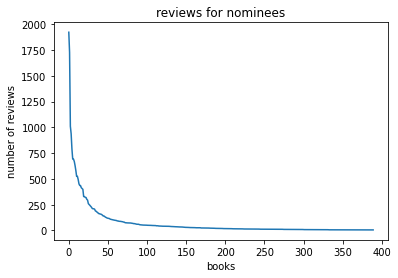

In [70]:
import matplotlib.pyplot as plt 

nreviews_nominee = predPivot[predPivot.labels==1].pred_count.sort_values(ascending=False)
nreviews_not = predPivot[predPivot.labels!=1].pred_count.sort_values(ascending=False)
xrange = list(range(0,len(nreviews_nominee)))
plt.plot(xrange,nreviews_nominee)
plt.xlabel('books')
plt.ylabel('number of reviews')
plt.title('reviews for nominees')
#plt.plot(list(range(0,len(nreviews_not))),nreviews_not)
plt.show()

## Take nlp predictions to predict the winners

We now have the percent predicted for each book with at least 5 reviews. Let's build a model that takes the things and gives us an output.

In [98]:
import sys
import time
from datetime import timedelta

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier # TRY THIS ONE!
from sklearn import svm

import concurrent.futures

# enable logging
logging.basicConfig( level=logging.INFO,
        format= "%(asctime)s: %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S",
        handlers=[
            logging.StreamHandler()
            ]
        )

In [83]:
print(predPivot.head())
X = predPivot[['n_votes_sum','pred_count','pred_sum']]
y = predPivot.labels

    book_id  labels  n_votes_sum  pred_count  pred_sum  pred_percent
0         1       1          135         260       115      0.442308
1  10016013       0            3          20        14      0.700000
2  10025305       0          383         217        71      0.327189
3  10031259       0           13          19         9      0.473684
4    100369       1            8          10         6      0.600000


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.33, random_state=42)

Classification report for classifier RandomForestClassifier(max_depth=50, random_state=0):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3807
           1       0.40      0.08      0.13       130

    accuracy                           0.97      3937
   macro avg       0.68      0.54      0.56      3937
weighted avg       0.95      0.97      0.95      3937


Confusion matrix:
[[3792   15]
 [ 120   10]]


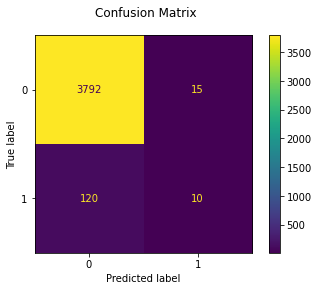

In [85]:
logging.info('Random Forest')
classifier = RandomForestClassifier(max_depth=50, random_state=0)
classifier.fit(X_train,y_train)
predicted = classifier.predict(X_test)
logging.info('complete')

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)


In [91]:
def my_model_eval(model,params,cv=2):
    # choose whether to run on small sample (for many runs and quick evaluation) or full set
               
    start_time = time.time()
    
    # run the sklearn model
    scoring = ['f1_macro','accuracy']
    logging.info('starting {} using {}'.format(model,params))
    classifier = model(**params)
    scores = cross_validate(classifier,X,y,cv=cv, scoring=scoring)
    fit_time_avg = np.mean(scores['fit_time'])
    score_time_avg = np.mean(scores['score_time'])
    f1_macro_avg = np.mean(scores['test_f1_macro'])
    accuracy_avg = np.mean(scores['test_accuracy'])
    # stop the clock
    end_time = time.time()
    elapsed = timedelta(seconds=(end_time - start_time))
    logging.info('stopping {} using {} after {}'.format(model,params,elapsed))
    r={}
    # helper function to get Sklearn object name from https://stackoverflow.com/a/54094521/6576560
    r['model']=model.__name__
    r['params']=json.dumps(params)
    r['fit_time_avg']=fit_time_avg
    r['score_time_avg']=score_time_avg
    r['f1_avg']=f1_macro_avg
    r['accuracy_avg']=accuracy_avg
    r['cv_elapsed']='{} elapsed'.format(elapsed)
    result = pd.DataFrame(r,index=[0])
    return result

In [89]:
# prior for nb
predPivot[predPivot.labels==1].book_id.nunique()/predPivot.book_id.nunique()

0.03269069572506287

In [101]:
to_search = [
    (RandomForestClassifier,{'max_depth':2})
    ,(RandomForestClassifier,{'max_depth':10})
    ,(RandomForestClassifier,{'max_depth':100})
    ,(svm.SVC,{'kernel':'linear','C':1})
    ,(svm.SVC,{'kernel':'rbf','C':1})
    ,(svm.SVC,{'kernel':'rbf','C':10})
    ,(svm.SVC,{'kernel':'poly','C':1})
    ,(GaussianNB,{"priors":[0.03,0.97]})
#    ,(AdaBoostClassifier,{"n_estimators":50})
#    ,(AdaBoostClassifier,{"n_estimators":100})
#    ,(HistGradientBoostingClassifier,{'max_iter':10,'max_depth':2}) # this breaks the concurrent futures module for no obvious reason
]

to_search = pd.DataFrame(to_search,columns=['model','params'])

In [92]:
def runModel(model,params):
    try:
       return my_model_eval(model,params)
    except Exception as e:
        logging.error(traceback.format_exc())

In [103]:
runModel(GaussianNB,{"priors":[0.03,0.97]})

,model,params,fit_time_avg,score_time_avg,f1_avg,accuracy_avg,cv_elapsed
0,GaussianNB,"{""priors"": [0.03, 0.97]}",0.004271,0.003344,0.578774,0.911484,0:00:00.019029 elapsed


In [102]:
myforecast = []

with concurrent.futures.ProcessPoolExecutor() as executor:
  results = executor.map(runModel,to_search['model'],to_search['params'])
  for result in results:
    myforecast.append(result)
   

results = pd.concat(myforecast,ignore_index=True)
display(results)

,model,params,fit_time_avg,score_time_avg,f1_avg,accuracy_avg,cv_elapsed
0,RandomForestClassifier,"{""max_depth"": 2}",0.175958,0.025919,0.491692,0.967309,0:00:00.410419 elapsed
1,RandomForestClassifier,"{""max_depth"": 10}",0.263998,0.047518,0.539130,0.966471,0:00:00.633970 elapsed
2,RandomForestClassifier,"{""max_depth"": 100}",0.281441,0.051397,0.547964,0.961861,0:00:00.677039 elapsed
3,SVC,"{""kernel"": ""linear"", ""C"": 1}",165.117654,0.013786,0.496810,0.967477,0:05:30.274687 elapsed
4,SVC,"{""kernel"": ""rbf"", ""C"": 1}",0.109521,0.055421,0.496801,0.967393,0:00:00.339447 elapsed
5,SVC,"{""kernel"": ""rbf"", ""C"": 10}",0.263779,0.067080,0.523079,0.966555,0:00:00.672040 elapsed
6,SVC,"{""kernel"": ""poly"", ""C"": 1}",11.360120,0.017424,0.518310,0.967896,0:00:22.766108 elapsed
7,GaussianNB,"{""priors"": [0.03, 0.97]}",0.005442,0.005059,0.578774,0.911484,0:00:00.027622 elapsed


Classification report for classifier GaussianNB(priors=[0.03, 0.97]):
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      3807
           1       0.09      0.61      0.15       130

    accuracy                           0.77      3937
   macro avg       0.53      0.69      0.51      3937
weighted avg       0.95      0.77      0.85      3937


Confusion matrix:
[[2964  843]
 [  51   79]]


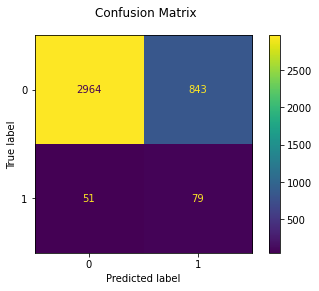

In [104]:
logging.info('Gaussian NB')
classifier = GaussianNB(priors=[0.03,0.97])
classifier.fit(X_train,y_train)
predicted = classifier.predict(X_test)
logging.info('complete')

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)
